In [ ]:
!pip install -qU langgraph langchain_community langchain_openai tavily-python

In [ ]:
import os

os.environ['OPENAI_API_KEY'] = 'YOUR_OPENAI_API_KEY'
os.environ['TAVILY_API_KEY'] = 'YOUR_TAVILY_API_KEY'

# Reasoning without Observation

In the **ReWOO** paper, the authors propose an agent that combines a multi-step planner and variable substitution for effective tool use. It was designed to improve on the ReACT-style agent architecture in the following ways:
1. Reduce token consumption and execution time by generating the full chain of tools used in a single pass. *(ReACT-style agent architecture requries many LLM calls with redundant prefixes since the system prompt and previous steps are provided to the LLM for each reasoning step)*
2. Simplify the fine-tuning process. Since the planning data does not depend on the outputs of the tool, models can be fine-tuned without actually invoking the tools.


ReWOO is made of 3 modules:
1. **Planner**: Generate the plan in the following format:
    ```
    Plan: <reasoning>
    #E1 = Tool[argument for tool]
    Plan: <reasoning>
    #E2 = Tool[argument for tool with #E1 variable substitution]
    ...
    ```
2. **Worker**: Executes the tool with the provided arguments.
3. **Solver**: Generates the answer for the initial task based on the tool observations.

Only the Planner and the Solver depend on an LLM call.

# Define Graph State

In LangGraph, every node updates a shared graph state. The state is the input to any node whenever it is invoked.

In [3]:
from typing import List
from typing_extensions import TypedDict

class ReWOO(TypedDict):
    task: str
    plan_string: str
    steps: List
    results: dict
    result: str

# Planner

The planner prompts an LLM to generate a plan in the form of a task list. The arguments to each task are strings that may contain special variables (`#E{0-9}+`) that are used for variable substitution from other task results.

In this section, our agent will have two tools: 1. search engine and 2. LLM - to reason about previous outputs.

The LLM tool receives less of the prompt context and so can be more token-efficient than the ReACT paradigm.

In [4]:
from langchain_openai import ChatOpenAI

model = ChatOpenAI(model='gpt-3.5-turbo')

In [5]:
prompt = """For the following task, make plans that can solve the problem step by step. For each plan, indicate
which external tool together with tool input to retrieve evidence. You can store the evidence into a
variable #E that can be called by later tools. (Plan, #E1, Plan, #E2, Plan, ...)

Tools can be one of the following:
(1) Google[input]: Worker that searches results from Google. Useful when you need to find short
and succinct answers about a specific topic. The input should be a search query.
(2) LLM[input]: A pretrained LLM like yourself. Useful when you need to act with general
world knowledge and common sense. Prioritize it when you are confident in solving the problem
yourself. Input can be any instruction.

For example,
Task: Thomas, Toby, and Rebecca worked a total of 157 hours in one week. Thomas worked x
hours. Toby worked 10 hours less than twice what Thomas worked, and Rebecca worked 8 hours
less than Toby. How many hours did Rebecca work?
Plan: Given Thomas worked x hours, translate the problem into algebraic expressions and solve
with Wolfram Alpha. #E1 = WolframAlpha[Solve x + (2x − 10) + ((2x − 10) − 8) = 157]
Plan: Find out the number of hours Thomas worked. #E2 = LLM[What is x, given #E1]
Plan: Calculate the number of hours Rebecca worked. #E3 = Calculator[(2 ∗ #E2 − 10) − 8]

Begin!
Describe your plans with rich details. Each Plan should be followed by only one #E.

Task: {task}
"""

In [6]:
task = "What is the exact hometown of the 2024 mens australian open winner?"
result = model.invoke(prompt.format(task=task))
print(result.content)

Plan: Use Google to search for the 2024 men's Australian Open winner. #E1 = Google[2024 men's Australian Open winner]
Plan: Once you have the name of the winner, use Google to search for their exact hometown. #E2 = Google[Hometown of [winner's name]]


## Planner Node

To connect the planner to our graph, we will create a `get_plan` node that accepts the `ReWOO` state and returns with a state update for the `steps` and `plan_string` fields.

In [15]:
import re

from langchain_core.prompts import ChatPromptTemplate

# Regex to match expressions of the form #E... = ...[...]
regex_pattern = r"Plan:\s*(.+)\s*(#E\d+)\s*=\s*(\w+)\s*\[([^\]]+)\]"
prompt_template = ChatPromptTemplate.from_messages([("user", prompt)])
planner = prompt_template | model


def get_plan(state: ReWOO):
    task = state['task']
    result = planner.invoke({'task': task})

    # Find all matches in the sample text
    matches = re.findall(regex_pattern, result.content)

    return {
        'steps': matches,
        'plan_string': result.content
    }

# Executor

The executor receives the plan and executes the tools in sequence.

In [16]:
from langchain_community.tools.tavily_search import TavilySearchResults

search = TavilySearchResults(max_results=3)

In [17]:
def _get_current_task(state: ReWOO):
    if 'results' not in state or state['results'] is None:
        return 1

    if len(state['results']) == len(state['steps']):
        return None
    else:
        return len(state['results']) + 1


def tool_execution(state: ReWOO):
    """Worker node that executes the tools of a given plan"""
    _step = _get_current_task(state)
    _, step_name, tool, tool_input = state['steps'][_step - 1]

    _results = (state['results'] or {}) if 'results' in state else {}

    for k,v in _results.items():
        tool_input = tool_input.replace(k, v)

    if tool == 'Google':
        result = search.invoke(tool_input)
    elif tool == 'LLM':
        result = model.invoke(tool_input)
    else:
        raise ValueError

    _results[step_name] = str(result)

    return {'results': _results}

# Solver

The solver receives the full plan and generates the final response based on the responses of the tool calls from the worker.

In [18]:
solve_prompt = """Solve the following task or problem. To solve the problem, we have made step-by-step Plan and
retrieved corresponding Evidence to each Plan. Use them with caution since long evidence might
contain irrelevant information.

{plan}

Now solve the question or task according to provided Evidence above. Respond with the answer
directly with no extra words.

Task: {task}
Response:
"""

def solve(state: ReWOO):
    plan = ""

    for _plan, step_name, tool, tool_input in state['steps']:
        _results = (state['results'] or {}) if 'results' in state else {}
        for k,v in _results.items():
            tool_input = tool_input.replace(k, v)
            step_name = step_name.replace(k, v)

        plan += f"Plan: {_plan}\n{step_name} = {tool}[{tool_input}]"

    prompt = solve_prompt.format(plan=plan, task=state['task'])
    result = model.invoke(prompt)

    return {'result': result.content}

# Define Graph

In [19]:
def _route(state):
    _step = _get_current_task(state)
    if _step is None:
        # We have executed all tasks
        return 'solve'
    else:
        # We are still executing tasks, loop back to the "tool" node
        return 'tool'

In [20]:
from langgraph.graph import START, END, StateGraph

graph = StateGraph(ReWOO)

graph.add_node('plan', get_plan)
graph.add_node('tool', tool_execution)
graph.add_node('solve', solve)

graph.add_edge(START, 'plan')
graph.add_edge('plan', 'tool')
graph.add_edge('solve', END)
graph.add_conditional_edges('tool', _route)

app = graph.compile()

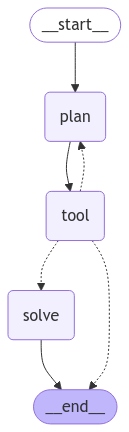

In [21]:
from IPython.display import Image, display

display(Image(
    app.get_graph(xray=True).draw_mermaid_png(),
))

In [22]:
for s in app.stream({"task": task}):
    print(s)
    print("---")

{'plan': {'plan_string': "Plan: Use Google to search for the winner of the 2024 men's Australian Open. #E1 = Google[2024 men's Australian Open winner]\nPlan: Once the winner is identified, use Google to search for their exact hometown. #E2 = Google[exact hometown of 2024 men's Australian Open winner]", 'steps': [("Use Google to search for the winner of the 2024 men's Australian Open. ", '#E1', 'Google', "2024 men's Australian Open winner"), ('Once the winner is identified, use Google to search for their exact hometown. ', '#E2', 'Google', "exact hometown of 2024 men's Australian Open winner")]}}
---
{'tool': {'results': {'#E1': '[{\'url\': \'https://www.cbssports.com/tennis/news/australian-open-2024-jannik-sinner-aryna-sabalenka-crowned-as-grand-slam-singles-champions-at-melbourne-park/\', \'content\': "Qinwen Zheng, 6-3, 6-2\\nOur Latest Tennis Stories\\nSinner, Sabalenka win Australian Open singles titles\\nSinner makes epic comeback to win Australian Open\\n2024 Australian Open odds

In [23]:
# Print out the final result
print(s["solve"]["result"])

The exact hometown of the 2024 men's Australian Open winner, Jannik Sinner, is Rome, Italy.
